In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.metrics import mean_squared_error

In [3]:
train_df = pd.read_csv('train_df_after_prep.csv', index_col='id')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 188533 entries, 0 to 188532
Data columns (total 19 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   milage                          188533 non-null  int64  
 1   fuel_type                       188533 non-null  object 
 2   accident                        188533 non-null  int64  
 3   price                           188533 non-null  int64  
 4   horse_power                     188533 non-null  float64
 5   engine_size                     188533 non-null  float64
 6   cylinder                        188533 non-null  float64
 7   transmission_speed              188533 non-null  float64
 8   transmission_type               188533 non-null  object 
 9   car_age                         188533 non-null  int64  
 10  yearly_mileage                  188533 non-null  float64
 11  model_class                     188533 non-null  object 
 12  brand_cat            

In [4]:
X = train_df.drop('price', axis=1)
y = train_df['price'].copy()

In [5]:
num_features = X.select_dtypes(exclude='object').columns
cat_1hot_features = ['fuel_type', 'transmission_type', 'ext_col_cat', 'int_col_cat']
cat_ord_features = ['model_class', 'brand_cat']

pipeline = ColumnTransformer([('num', StandardScaler(), num_features), 
                              ('cat_1hot', OneHotEncoder(), cat_1hot_features),
                              ('model_class', OrdinalEncoder(categories=[['Base', 'Mid-Range', 'Performance/Sport', 'Luxury']]), ['model_class']),
                              ('brand_cat', OrdinalEncoder(categories=[['Economy', 'Mainstream', 'Premium', 'Luxury', 'Supercars']]), ['brand_cat'])
                              ])
X = pipeline.fit_transform(X)

Nhận xét: 
- Hệ số tương quan Pearson của các numerical features so với price thấp (trong file FeatureEngineering)
- Có 4 nominal features
- Có 2 ordinal features là brand_cat và model_class, tuy nhiên chỉ có brand_cat là phân bố hợp lý, còn model_class phân bố bị ngược ở tập train
(Thông qua plot ở file FeatureEngineering)

Do đó, sử dụng các mô hình tuyến tính trực tiếp sẽ không đạt hiệu quả cao trong bài toán này. Thay vào đó, chúng tôi sẽ sử dụng các model có thể xử lý tốt dataset có trộn lẫn numerical features, categorical features, đồng thời mối quan hệ của chúng với price là non-linear là Random Forest và XGBoost
Ở đây chúng tôi chỉ sử dụng Ridge đại diện cho các mô hình tuyến tính để so sánh với Random Forest và XGBoost

# 1. Lựa chọn (Tối ưu) tham số

Sử dụng tập train để lựa chọn tham số:
- Ridge: `alpha`
- RandomForest: `n_estimators`, `max_features`, `max_depth`
- XGBoost: `n_estimators`, `max_depth`


Ta sẽ sử dụng chiến lược cross_validation trong bước này

In [7]:
def cross_validation(estimator,param_grid,X):

    grid_search = GridSearchCV(estimator, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
    grid_search.fit(X, y)
    cvres = grid_search.cv_results_
    
    # Compute RMSE for each fold (test and train)
    test_rmse_folds = [
        [np.sqrt(-cvres[f"split{i}_test_score"][j]) for i in range(5)] 
        for j in range(len(cvres["params"]))
    ]
    train_rmse_folds = [
        [np.sqrt(-cvres[f"split{i}_train_score"][j]) for i in range(5)] 
        for j in range(len(cvres["params"]))
    ]
    
    # Calculate mean and std RMSE
    results_df = pd.DataFrame({
        'params': cvres["params"],
        'mean_test_rmse': [np.mean(rmse) for rmse in test_rmse_folds],
        'std_test_rmse': [np.std(rmse) for rmse in test_rmse_folds],
        'mean_train_rmse': [np.mean(rmse) for rmse in train_rmse_folds],
        'std_train_rmse': [np.std(rmse) for rmse in train_rmse_folds],
    })
    
    sorted_df = results_df.sort_values(by='mean_test_rmse', ascending=True)
    
    return sorted_df

# 1.1. Đánh giá hiệu quả của các giá trị `alpha` khi sử dụng `Ridge`

In [33]:
ridge_params = [{'alpha':[0.0001,0.001,0.01,0.1,1,10,100]}]

In [34]:
ridge = Ridge()
assessment_table = cross_validation(ridge,ridge_params,X)
assessment_table

,params,mean_test_rmse,std_test_rmse,mean_train_rmse,std_train_rmse
5,{'alpha': 10},73992.962006,3658.390288,74052.174490,890.012459
4,{'alpha': 1},73993.049534,3658.142172,74052.129472,890.010374
3,{'alpha': 0.1},73993.063122,3658.115854,74052.128783,890.010350
2,{'alpha': 0.01},73993.064558,3658.113206,74052.128775,890.010349
1,{'alpha': 0.001},73993.064703,3658.112941,74052.128775,890.010349
0,{'alpha': 0.0001},73993.064717,3658.112915,74052.128775,890.010349
6,{'alpha': 100},73993.120113,3660.300431,74053.407881,890.046408


Mặc dù mean của price là 43000 nên RMSE đạt ~ 74000 chắc chắn bị coi là underfitting. Tuy nhiên ở đây xét theo top 1 trên kaggle chỉ đạt 62917.05988 khi chấm với 80% của tập test nên mục tiêu của bài này sẽ là tìm cách sao cho RMSE gần hơn với con số 62917 trên tập test.

Các giá trị alpha đều cho các giá trị RMSE ở cả tập train và test ngang nhau về cả mean và std.
Ta sẽ lấy alpha = 10.

# 1.2. Đánh giá độ hiệu quả của các giá trị `n_estimators`, `max_features`, `max_depth` khi sử dụng `RandomForest`

1.4.1. Đánh giá độ hiệu quả của các giá trị `n_estimators`, `max_features` ,`max_depth`

In [30]:
param_grid = [{"n_estimators":[50,80,100],"max_features":[2,4,8,12],"max_depth":[2,4,8,12,None]}]

In [31]:
RF_reg = RandomForestRegressor()
assessment_table = cross_validation(RF_reg,param_grid,X)
assessment_table

,params,mean_test_rmse,std_test_rmse,mean_train_rmse,std_train_rmse
35,"{'max_depth': 8, 'max_features': 12, 'n_estima...",73049.467147,3715.654323,67539.107291,927.765903
34,"{'max_depth': 8, 'max_features': 12, 'n_estima...",73099.867564,3671.581676,67428.064584,825.188483
32,"{'max_depth': 8, 'max_features': 8, 'n_estimat...",73147.406475,3711.482197,68819.292704,930.427022
33,"{'max_depth': 8, 'max_features': 12, 'n_estima...",73151.038189,3680.314284,67421.696687,814.351088
31,"{'max_depth': 8, 'max_features': 8, 'n_estimat...",73181.217362,3698.427757,68781.461456,946.375401
30,"{'max_depth': 8, 'max_features': 8, 'n_estimat...",73188.606578,3735.769568,68917.196728,935.519105
41,"{'max_depth': 12, 'max_features': 4, 'n_estima...",73231.500919,3740.402079,62646.285913,760.849763
40,"{'max_depth': 12, 'max_features': 4, 'n_estima...",73232.075498,3743.990299,62704.589388,840.012190
29,"{'max_depth': 8, 'max_features': 4, 'n_estimat...",73339.780571,3679.343856,71169.910383,858.579124
39,"{'max_depth': 12, 'max_features': 4, 'n_estima...",73357.584024,3742.996129,62585.766196,837.152364


Giá trị tối ưu nhất là max_depth = 8, max_features = 12, n_estimators = 100

# 1.3. Đánh giá độ hiệu quả của các giá trị `n_estimators`, `max_depth` trong XGBoost

1.5.1. Đánh giá độ hiệu quả của các giá trị `n_estimators`, `max_depth`

In [28]:
from xgboost import XGBRegressor

param_grid = [{"n_estimators":[10,20,30,40,50,60,70,80,90,100],"max_depth":[2,3,4,5,6,7,8,9,10,20,30]}]

XGB_reg= XGBRegressor(
    objective='reg:squarederror',
    learning_rate=0.05,           # Step size shrinkage
    subsample=0.8,                # Randomly sample training data
    colsample_bytree=0.8,         # Randomly sample features for each tree
    random_state=42
)

assessment_table = cross_validation(XGB_reg,param_grid,X)
assessment_table

C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


,params,mean_test_rmse,std_test_rmse,mean_train_rmse,std_train_rmse
29,"{'max_depth': 4, 'n_estimators': 100}",72884.705244,3662.100625,71874.917514,908.522479
38,"{'max_depth': 5, 'n_estimators': 90}",72889.254074,3692.791250,70555.748294,937.086826
37,"{'max_depth': 5, 'n_estimators': 80}",72898.624071,3693.692484,70785.726599,951.501694
39,"{'max_depth': 5, 'n_estimators': 100}",72901.513928,3689.917723,70294.951923,945.942523
28,"{'max_depth': 4, 'n_estimators': 90}",72902.952693,3671.717573,72005.335842,896.245715
...,...,...,...,...,...
107,"{'max_depth': 30, 'n_estimators': 80}",79336.790782,3698.722654,20604.438324,865.544941
98,"{'max_depth': 20, 'n_estimators': 90}",79370.086138,3656.399404,21792.047326,834.151952
99,"{'max_depth': 20, 'n_estimators': 100}",79729.562138,3667.133952,20429.496309,921.567670
108,"{'max_depth': 30, 'n_estimators': 90}",79807.114491,3674.136663,18896.956702,968.608852


Giá trị tối ưu là max_depth = 4, n_estimators = 100

# 2. So sánh các mô hình
- Sau khi chọn được bộ tham số tốt cho các mô hình, ta huấn luyện trên toàn bộ tập train.
- Ta sẽ lấy Ridge để đại diện cho các mô hình LinearRegression và so sánh nó với RandomForest

In [38]:
Ridge_reg = Ridge(alpha = 10)
RF_reg = RandomForestRegressor(n_estimators=100,max_features = 12,max_depth = 8)
XGB_reg= XGBRegressor(
    objective='reg:squarederror',
    max_depth = 4,
    n_estimators = 100,
    learning_rate = 0.05,           # Step size shrinkage
    subsample = 0.8,                # Randomly sample training data
    colsample_bytree = 0.8,         # Randomly sample features for each tree
    random_state = 42
)

Ta sẽ so sánh dựa trên hai độ đo:
- Tính khả mở (Scalability)
- RMSE score

# 2.1. So sánh các mô hình dựa trên tính khả mở (Scalability)

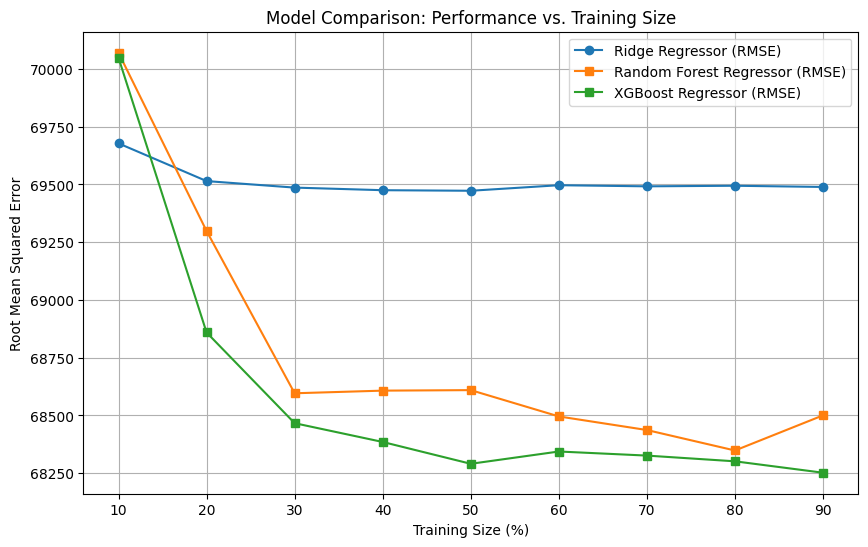

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

training_sizes = np.linspace(0.1, 0.9, 9)  # 10% to 90% of the training data
ridge_scores, rf_scores, xgb_scores = [], [], []

# Evaluate both models on varying training sizes
for frac in training_sizes:
    X_train_frac, _, y_train_frac, _ = train_test_split(X_train, y_train, train_size=frac, random_state=42)
    
    Ridge_reg.fit(X_train_frac, y_train_frac)
    y_pred_sgd = Ridge_reg.predict(X_val)
    ridge_scores.append(np.sqrt(mean_squared_error(y_val, y_pred_sgd)))
    
    XGB_reg.fit(X_train_frac, y_train_frac)
    y_pred_sgd = XGB_reg.predict(X_val)
    xgb_scores.append(np.sqrt(mean_squared_error(y_val, y_pred_sgd)))

    RF_reg.fit(X_train_frac, y_train_frac)
    y_pred_rf = RF_reg.predict(X_val)
    rf_scores.append(np.sqrt(mean_squared_error(y_val, y_pred_rf)))

plt.figure(figsize=(10, 6))
plt.plot(training_sizes * 100, ridge_scores, marker='o', label='Ridge Regressor (RMSE)')
plt.plot(training_sizes * 100, rf_scores, marker='s', label='Random Forest Regressor (RMSE)')
plt.plot(training_sizes * 100, xgb_scores, marker='s', label='XGBoost Regressor (RMSE)')
plt.xlabel('Training Size (%)')
plt.ylabel('Root Mean Squared Error')
plt.title('Model Comparison: Performance vs. Training Size')
plt.legend()
plt.grid()
plt.show()

Nhận xét về tính khả mở: Ridge < Random Forest < XGBoost

# 2.2. So sánh các mô hình dựa trên RMSE score

In [40]:
test_df = pd.read_csv('test_df_after_prep.csv', index_col='id')

In [41]:
X_test = pipeline.transform(test_df)
Ridge_reg.fit(X,y)
RF_reg.fit(X,y)
XGB_reg.fit(X,y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [42]:
y_pred_Ridge = Ridge_reg.predict(X_test)
y_pred_RF = RF_reg.predict(X_test)
y_pred_XGB = XGB_reg.predict(X_test)

In [43]:
Ridge_submission_file = test_df.reset_index()[['id']]
Ridge_submission_file['price'] = y_pred_Ridge
Ridge_submission_file.set_index('id', inplace=True)
Ridge_submission_file.to_csv('Ridge_submission.csv')

In [46]:
RF_submission_file = test_df.reset_index()[['id']]
RF_submission_file['price'] = y_pred_RF
RF_submission_file.set_index('id', inplace=True)
RF_submission_file.to_csv('RF_submission.csv')

In [45]:
XGB_submission_file = test_df.reset_index()[['id']]
XGB_submission_file['price'] = y_pred_XGB
XGB_submission_file.set_index('id', inplace=True)
XGB_submission_file.to_csv('XGB_submission.csv')

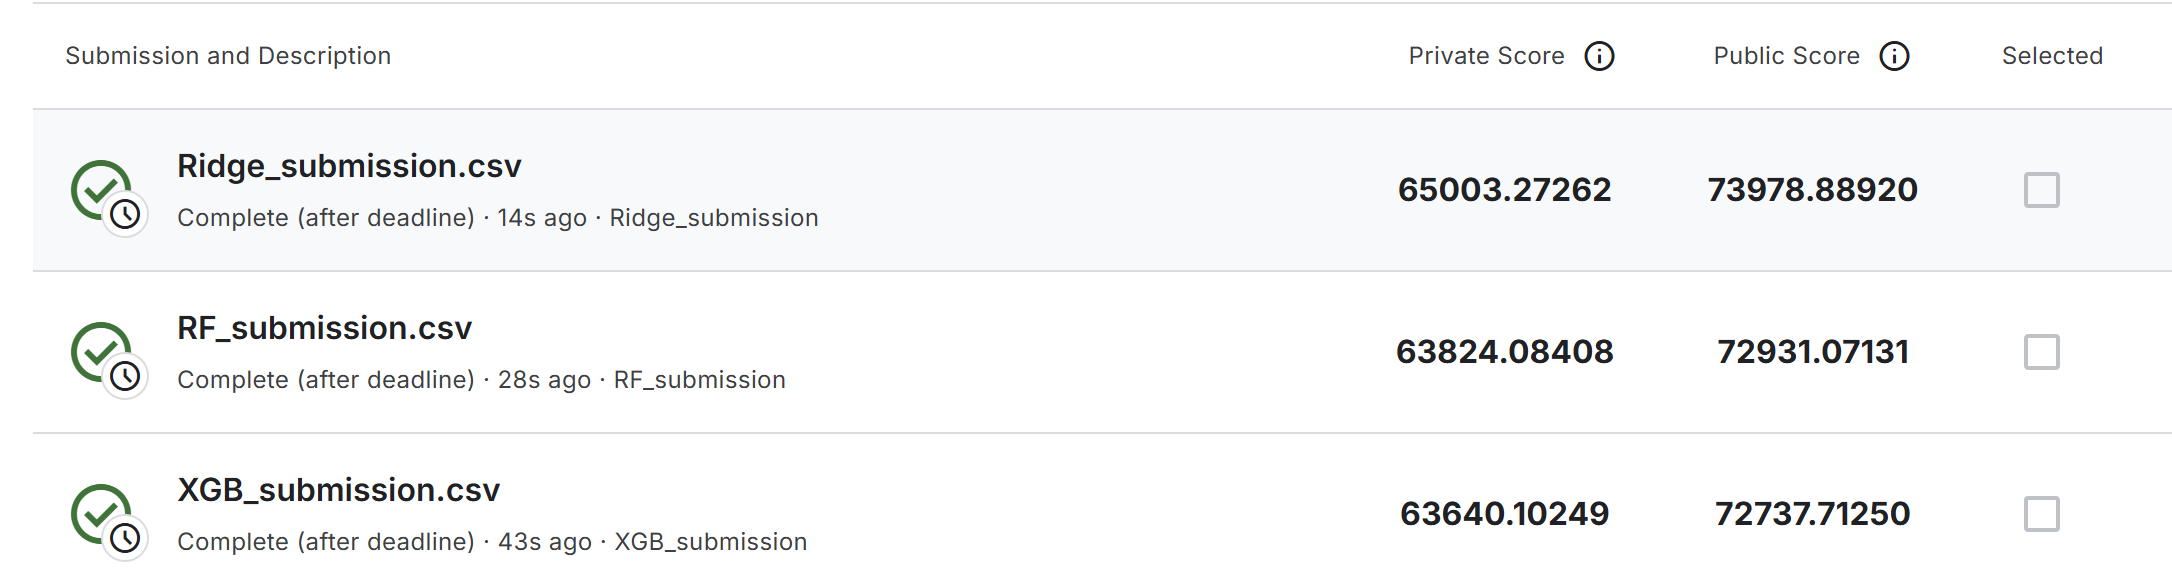

Chú thích: Public Score chỉ tính score trên 20% dữ liệu trên tập test, còn Private Score tính score trên 80% dữ liệu của tập test.
So với xếp hạng Leaderboard trên kaggle (xếp theo Private Score), top 1 đạt 62917.05988, XGB_submission khoảng top 1407 trên 3306 người tham gia.